In [56]:
ignore_keys=['rp','r','jk','cov','corr','jk_err','jkerr','data','data0']
class cov_corr():
    def mean_calc(self,data=[],axis=1):
        return np.mean(data,axis)

    def var_calc(self,data=[],axis=1):
        return np.var(data,axis)

    def residual_calc(self,data=[],axis=1): #calculate residual that go into cov calculation, y-E(y)
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        #print dim0,dim1,axis
# since mean is always 1-d array, [mean]*dim1 always give matrix [dim0 X dim1]...
#hence depending on dimension of data may need to transpose to get correct residuals
        try:
            res=data-np.transpose([mean]*dim1)
            print ("transpose")
        except:
            res=data-[mean]*dim1
        return res

    def cov_matrix2(self,data=[],axis=1,ddof=0):
        return np.cov(data,rowvar=axis)

    def cov_matrix(self,data=[],axis=1,ddof=0):
        #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean=self.mean_calc(data,axis)
        dim0=len(mean)
        dim1=np.shape(data)[axis]
        res=self.residual_calc(data=data,axis=axis)
        cov=np.zeros((dim0,dim0))
        if len(res[0])!=dim1:
            res=np.transpose(res)#residual has dimension of data..
                                #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim0):
                cov[i][j]+=np.sum(res[i]*res[j])
        cov/=np.float64(dim1-ddof)
        return cov

    def cross_cov_matrix2(self,data1=[],data2=[],axis=1,ddof=0):
        cross_cov=np.cov(data1,data2,rowvar=axis)
        N1=len(data1[0])
        N2=len(data2[0])
        cov2=np.zeros((N1,N2))
        for i in np.arange(N1):
            for j in np.arange(N2):
                cov2[i][j]=cross_cov[i+N1][j]
        return cov2

    def cross_cov_matrix(self,data1=[],data2=[],axis=1,ddof=0):
    #return np.cov(data,rowvar=axis,ddof=1) #ddof=0 for correct variance
        mean1=self.mean_calc(data1,axis)
        mean2=self.mean_calc(data2,axis)
        dim0=len(mean1)
        dim2=len(mean2)
        dim1=np.shape(data1)[axis]
        res1=self.residual_calc(data=data1,axis=axis)
        res2=self.residual_calc(data=data2,axis=axis)
        cov=np.zeros((dim0,dim2))
        if dim0!=dim2:
            print ('cross cov: dimensions of data 1 and data2 not equal')
        if len(res1[0])!=dim1:
            res2=np.transpose(res2)
            res1=np.transpose(res1)#residual has dimension of data..
                            #depending on axis value, may need to transpose for correct covariance
        for i in np.arange(dim0):
            for j in np.arange(dim2):
                cov[i][j]+=np.sum(res1[i]*res2[j])
        cov/=np.float64(dim1-ddof)
        return cov

    #for some reason numpy covariance matrix has some constant multiplied to it..
    #seems to be some func of N but can't figure it out.
    #this func returns that constants value by comparing it with variance
    def var_cov_comparison(self,var=[],cov=[]):
        l=len(cov[0])
        v2=np.zeros_like(var)
        for i in np.arange(l):
            v2[i]=cov[i][i]
        r=var/v2
        x=r==r[0]
        if sum(x)<l:
            print ("variance-covariance miss match") #return full ratio array in case r is not constant
            return r  #note comparison can be easily fooled due to floating point error
        return [r[0]]

    def corr_matrix(self,cov_mat=[]): #correlation matrix
        diag=np.diag(cov_mat)
        return cov_mat/np.sqrt(np.outer(diag,diag))
        # dim=len(cov_mat[0])
        # var=np.zeros(dim)
        # corr=np.zeros((dim,dim))
        # for i in np.arange(dim):
        #     var[i]=cov_mat[i][i]
        # for i in np.arange(dim):
        #     for j in np.arange(dim):
        #         corr[i][j]=cov_mat[i][j]/np.sqrt(var[i]*var[j])
        # return corr

    def cross_corr_matrix(self,cov_mat=[],data1=[],data2=[],axis=1): #correlation matrix
        dim=len(cov_mat[0])
        var1=self.var_calc(data1,axis)
        var2=self.var_calc(data2,axis)
        corr=np.zeros((dim,dim))
#        for i in np.arange(dim):
 #           var[i]=cov_mat[i][i]
        for i in np.arange(dim):
            for j in np.arange(dim):
                corr[i][j]=cov_mat[i][j]/np.sqrt(var1[i]*var2[j])
        return corr

    #stack column from various dictionary elements to get a data matrix which goes into covariance calculations
    #incase dict elements have several columns, var defines the column to be used. better to have named columns
    def dict_stack(self,dic={},var='',ignore_keys=ignore_keys):
        keys=dic.keys()
        j=0
        mat=[]
        axis=0
        for i in keys:
            if i in ignore_keys:
                #print 'cov_corr.dict_stack::',i,'ignored in stacking'
                continue
            if j==0:
                if not check_empty(var):
                    mat=dic[i][var]
                else:
                    mat=dic[i]#[:]
                j=j+1
                continue
            if not check_empty(var):
                mat=np.vstack((mat,dic[i][var]))
            else:
                mat=np.vstack((mat,dic[i]))#dic[i][:]
        return mat,axis


    def dict_cov(self,dic={},var='',stack=0,axis=0,ddof=0,ignore_keys=ignore_keys):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat,axis=self.dict_stack(dic=dic,var=var,ignore_keys=ignore_keys)
            #print "cov_corr: dictionary stacked"
        if stack==0:
            #print "no stacking:",var,axis
            mat=dic[var]
            axis=axis
        cov=self.cov_matrix2(data=mat,axis=axis,ddof=ddof)
        #print cov.shape
        corr=self.corr_matrix(cov)
        return cov,corr


    def dict_cross_cov(self,dic={},dic2={},var1='',var2='',stack=0,axis=0,ddof=0):
        if stack!=0:
            #print "cov_corr: Stacking dictionary"
            mat1,axis=self.dict_stack(dic=dic,var=var1)
            if dic2:
                mat2,axis=self.dict_stack(dic=dic2,var=var2)
            else:
                mat2,axis=self.dict_stack(dic=dic,var=var2)
        if stack==0:
            #print "no stacking:",var,axis
            mat1=dic[var1]
            if dic2:
                mat2=dic2[var2]
            else:
                mat2=dic[var2]
            axis=axis
        cov=self.cross_cov_matrix2(data1=mat1,data2=mat2,axis=axis,ddof=ddof)
        corr=self.cross_corr_matrix(cov_mat=cov,data1=mat1,data2=mat2,axis=axis)
        return cov,corr

    def matrix_diagonalize(self,m=[]):
        N1=len(m)
        N2=len(m[0])
        for i in np.arange(N1):
            for j in np.arange(N2):
                if i==j:
                    continue
                m[i][j]=0
        return m

    def mat_inv(self,m=[]):
        return np.linalg.inv(m)

    def matrix_cut(self,mat=[],x=[]):
        m=mat[x]
        N=sum(x)
        m2=np.zeros((N,N))
        j=0
        for i in m:
            m2[j]=i[x]
            j=j+1
        return m2

    def chi_sq(self,theory=[],data=[],x=[],cov=[]):
        if len(x):
            data=data[x]
            theory=theory[x]
            cov=self.matrix_cut(mat=cov,x=x)
        cov_inv=self.mat_inv(m=cov)
        #print data.shape,theory.shape,cov.shape,cov_inv.shape
        N=len(data)
        chi_sq=0
        for i in np.arange(N):
            for j in np.arange(N):
                chi_sq+=((data[i]-theory[i])*(data[j]-theory[j])*(cov_inv[i][j]))
        #chi_sq/=2.
        return chi_sq,N
def check_empty(arr): # True is empty
    try:
        #print not arr.any()
        try:
            return not arr.any()
        except:
            if arr.size!=0: #for rec array
                return False
            else:
                return True
    except:
        #print not bool(arr)
        return not bool(arr) #for other python types, including dictionary

In [57]:
def jk_read(dataset='',var=None,njk=100,auto_cross='_cross',bins='_bins',
            home='',corr='_final',skiprows=0,**kwargs):
    data_jk={}
    filename=dataset
    try:
        data_jk['data']=np.genfromtxt(home+filename+bins+auto_cross+'_jk_final.dat',
                                      names=True,skip_header=skiprows)
    except:
        print ('file not found')
    try:
        data_jk['data0']=np.genfromtxt(home+filename+bins+auto_cross+corr+'.dat',
                                       names=True,skip_header=skiprows)
    except:
        print ('file not found')
    for i in np.arange(njk):
        data_jk[i]=np.genfromtxt(home+filename+bins+auto_cross+'_jk'+str(i)+corr+'.dat',names=True,
                                 skip_header=skiprows)
    cc=cov_corr()
    if var and njk>0:
        data_jk['cov']={}
        data_jk['corr']={}
        for v in var:
            cov,corr=cc.dict_cov(dic=data_jk,var=v,stack=1,ignore_keys=['data','data0','cov','corr'])
            cov*=njk-1.
            data_jk['cov'][v]=cov
            data_jk['corr'][v]=corr
    return data_jk


In [58]:
file_home='./temp/ill_test/corr_data_out/'
file_name='ill_test_ED'

In [59]:
njk=49

In [60]:
%pylab inline
w_jk=jk_read(dataset=file_name,var=['wgg','theta'],njk=njk,auto_cross='_cross',bins='_bins',
            home=file_home,corr='_final',skiprows=0)
#wgg == xi_gg
#theta= cos^2.. need to subtract 1./3

Populating the interactive namespace from numpy and matplotlib


/hildafs/verafs-scratch/phy200017p/yjagvara/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [61]:
w_jk.keys()

dict_keys(['data', 'data0', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 'cov', 'corr'])

'data': contains the jackknife mean and the jackknife errorbars

'data0': Contains the full sample measurements. Do not use the errorbars from this set.

0....njk-1: Contains measurements from the respective jackknife regions.

cov, corr: Covariance and correlation matrices for the variables passed.

In [62]:
w_jk['data0']


array([(0.129245,    35832., 4.69257e+02, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0210672 , 0., 0., 0., 0.1     ,  0.158489, 0.),
       (0.204839,    85042., 2.79348e+02, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0208505 , 0., 0., 0., 0.158489,  0.251189, 0.),
       (0.324648,   192554., 1.58447e+02, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0206736 , 0., 0., 0., 0.251189,  0.398107, 0.),
       (0.514532,   390896., 8.03065e+01, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0212949 , 0., 0., 0., 0.398107,  0.630957, 0.),
       (0.815479,   712220., 3.62116e+01, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0234827 , 0., 0., 0., 0.630957,  1.      , 0.),
       (1.29245 ,  1101163., 1.34516e+01, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.023331  , 0., 0., 0., 1.      ,  1.58489 , 0.),
       (2.04839 ,  1742445., 4.74412e+00, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.0150267 , 0., 0., 0., 1.58489 ,  2.51189 , 0.),
       (3.24648 ,  3828215., 2.17001e+00, 0., 0.

/tmp/ipykernel_865279/2567572053.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  errorbar(rp, w_jk['data0']['theta']*5,w_jk['data']['theta_err'],fmt='bo', color='green', label='if multiplied by 5')


(0.1, 50)

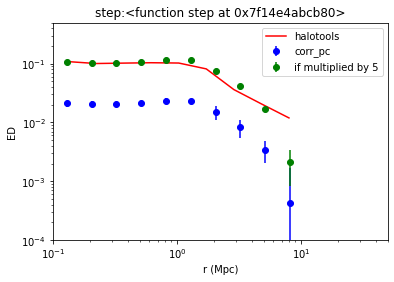

In [85]:
#https://github.com/duncandc/halotools_ia
# halotool needs to be in alignments_dev branch
rbins = np.logspace(-1, 1, 10)
center = (rbins[:-1] + rbins[1:]) / 2
from halotools_ia.correlation_functions  import ed_3d,ee_3d, ed_3d_one_two_halo_decomp


ed  = ed_3d(np.vstack((tng['x'], tng['y'], tng['z'])).T, np.vstack((tng['dm_av_x'], tng['dm_av_y'], tng['dm_av_z'])).T,   np.vstack((tng['x'], tng['y'], tng['z'])).T,  rbins, period=75)

errorbar(center, ed ,label='halotools', color='red')
loglog()



rp=w_jk['data0']['rp']
 
errorbar(rp, w_jk['data0']['theta'],w_jk['data']['theta_err'],fmt='bo', label='corr_pc')

errorbar(rp, w_jk['data0']['theta']*5,w_jk['data']['theta_err'],fmt='bo', color='green', label='if multiplied by 5')


ylim(0.0001, 0.5)
legend()
title('step:' +str(step))
ylabel('ED')
xlabel('r (Mpc)')
xscale('log')
yscale('log')
xlim(0.1,50)
# plot(rp,rp*(wgg2.reshape(10,200).sum(axis=1)))
# plot(rp,rp*(wgg_pic.reshape(10,80).sum(axis=1)))

In [53]:
import pickle

tng = pickle.load(  open('/hildafs/projects/phy200017p/yjagvara/some_data/TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl', "rb" ) )
tng['x'] = tng['gal_pos_x']
tng['y'] = tng['gal_pos_y']
tng['z'] = tng['gal_pos_z']

In [54]:
rbins.shape

(10,)

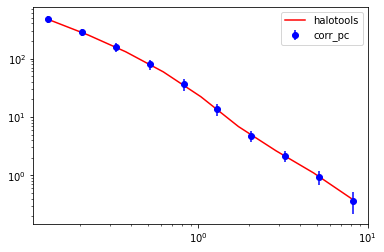

In [72]:

from  halotools_ia  import *
from  halotools.mock_observables import tpcf
rbins = np.logspace(-1, 1, 10)
center = (rbins[:-1] + rbins[1:]) / 2
htools =   tpcf(np.vstack((tng['x'], tng['y'], tng['z'])).T, rbins, period=75)
errorbar(center, htools,label='halotools', color='red')
loglog()

rp=w_jk['data0']['rp']
errorbar(rp, w_jk['data0']['wgg'],w_jk['data']['wgg_err'],fmt='bo',label='corr_pc')
loglog()
legend()


In [32]:
rp=w_jk['data0']['rp']
errorbar(rp,rp*w_jk['data0']['theta'],rp*w_jk['data']['theta_err'],fmt='bo')
loglog()

//hildafs/projects/phy200040p/sukhdeep/miniconda3/envs/intel/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


[]

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x15032831c3a0> (for post_execute):


ValueError: Data has no positive values, and therefore can not be log-scaled.

ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 1500x1125 with 1 Axes>

# For derived quantities such as bias, compute jk errors as follows:

In [33]:
# say we want to compute bias using wgg/wmm ratio
wgg=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins',
            home=file_home,corr='_final',skiprows=0) 

wmm=jk_read(dataset=file_name,var=['wgg','wgp'],njk=njk,auto_cross='_cross',bins='_bins',
            home=file_home,corr='_final',skiprows=0)

/tmp/ipykernel_4041736/3832086727.py:91: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/np.sqrt(np.outer(diag,diag))


In [34]:
bias={}
njk=njk
for i in np.arange(njk):
    bias[i]=np.sqrt(wgg[i]['wgg']/wmm[i]['wgg'])
cc=cov_corr()
bias['cov'],bias['corr']=cc.dict_cov(dic=bias,stack=1) #in this example values are non-sensicle because we used the same calculations for wgg and wmm.

/tmp/ipykernel_4041736/3832086727.py:91: RuntimeWarning: invalid value encountered in true_divide
  return cov_mat/np.sqrt(np.outer(diag,diag))
